In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Activation
from keras.layers import GlobalMaxPooling2D, MaxPooling2D
from keras.optimizers import Adam

%matplotlib inline

In [23]:
DATA_FILE = 'data/pp_train_data.h5'
METADATA = 'metadata.npy'

In [3]:
f = h5py.File(DATA_FILE, 'r')
data_x = f['x']
data_y = f['y']
metadata = np.load(METADATA).item()

In [4]:
lr = 1e-3
n_conv_layers = 3
n_kernels = [128] * n_conv_layers
mp_sizes = [(2,2) for _ in range(n_conv_layers)]

model = Sequential()
model.add(BatchNormalization(axis=3, input_shape=data_x.shape[1:]))
for i in range(n_conv_layers):
    model.add(Conv2D(n_kernels[i], 3, 3, init='he_uniform', border_mode='same'))
    model.add(BatchNormalization(axis=3))
    model.add(Activation('relu'))
    if i < n_conv_layers - 1:
        model.add(MaxPooling2D(mp_sizes[i]))

model.add(Conv2D(8,3,3, border_mode='same'))
model.add(GlobalMaxPooling2D())
model.add(Activation('softmax'))
model.compile(Adam(lr), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 9, 15, 512)    2048        batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 9, 15, 128)    589952      batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 9, 15, 128)    512         convolution2d_1[0][0]            
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 9, 15, 128)    0           batchnormalization_2[0][0]       
___________________________________________________________________________________________

In [5]:
from sklearn.model_selection import train_test_split

data_x = np.asarray(data_x)
data_y = np.asarray(data_y)
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.15, random_state=42)

del(data_x)
del(data_y)

In [6]:
model.fit(X_train, y_train, batch_size=64, nb_epoch=5,
          validation_data=(X_test, y_test))

Train on 3210 samples, validate on 567 samples
Epoch 1/5
3210/3210 [==============================] - 10s - loss: 0.6710 - acc: 0.7857 - val_loss: 0.5319 - val_acc: 0.8907
Epoch 2/5
3210/3210 [==============================] - 6s - loss: 0.0692 - acc: 0.9850 - val_loss: 0.1820 - val_acc: 0.9453
Epoch 3/5
3210/3210 [==============================] - 6s - loss: 0.0162 - acc: 0.9972 - val_loss: 0.2187 - val_acc: 0.9524
Epoch 4/5
3210/3210 [==============================] - 6s - loss: 0.0054 - acc: 0.9994 - val_loss: 0.1556 - val_acc: 0.9612
Epoch 5/5
3210/3210 [==============================] - 6s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.1587 - val_acc: 0.9647


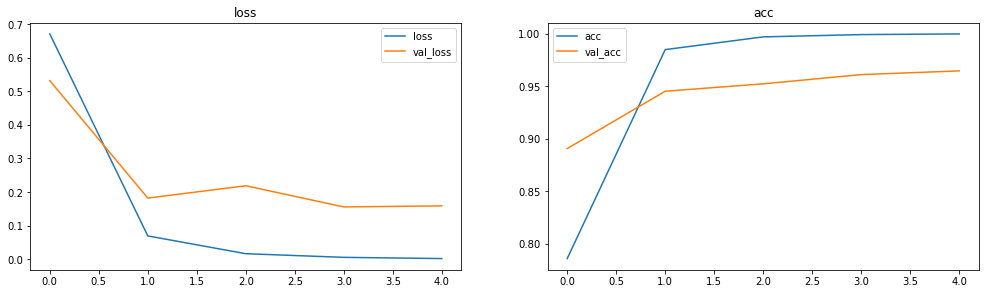

In [8]:
def plot_model(model):
    plots = [i for i in model.model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(17,10))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.model.history.history[p], label=p)
        plt.plot(model.model.history.history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()
    
plot_model(model)

Train on 3210 samples, validate on 567 samples
Epoch 1/5
3210/3210 [==============================] - 6s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.1543 - val_acc: 0.9647
Epoch 2/5
3210/3210 [==============================] - 6s - loss: 0.0012 - acc: 1.0000 - val_loss: 0.1531 - val_acc: 0.9647
Epoch 3/5
3210/3210 [==============================] - 6s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.1517 - val_acc: 0.9647
Epoch 4/5
3210/3210 [==============================] - 6s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.1515 - val_acc: 0.9647
Epoch 5/5
3210/3210 [==============================] - 6s - loss: 0.0010 - acc: 1.0000 - val_loss: 0.1519 - val_acc: 0.9647


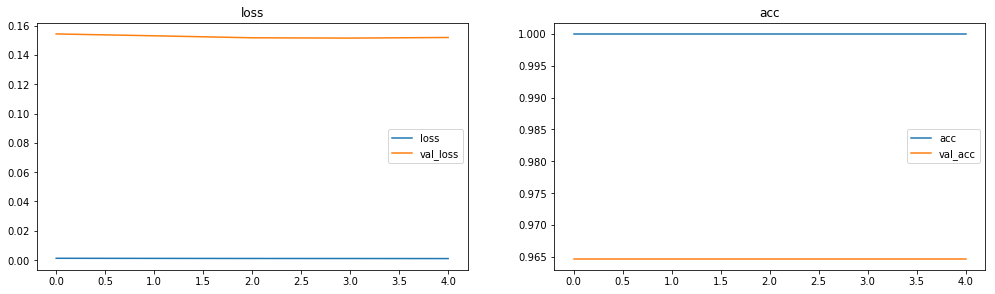

In [11]:
from keras import backend as K

K.eval(model.optimizer.lr.assign(1e-4))
model.fit(X_train, y_train, batch_size=64, nb_epoch=5,
          validation_data=(X_test, y_test))
plot_model(model)

In [12]:
model.save('model1.h5')

# Build submit file

In [3]:
from keras.models import load_model

model = load_model('model1.h5')

In [13]:
import os
import PIL
from keras.applications.vgg16 import preprocess_input, VGG16

DATA_FOLDER = 'data/test'
PP_TEST_DATA = 'data/pp_test_data.npy'
SHAPE = (300, 500, 3)

files = os.listdir(DATA_FOLDER)
n_files = len(files)

In [34]:
batch_x = np.ndarray((n_files, *SHAPE), dtype=np.float32)

for idx, file in enumerate(files):
    print('%04d/%04d' % (idx, n_files), end='\r')
    path = os.path.join(DATA_FOLDER, file)
    img = PIL.Image.open(path)
    img = img.resize(SHAPE[:2][::-1])
    img = np.asarray(img, dtype=np.float32)
    batch_x[idx] = img

In [36]:
batch_x = preprocess_input(batch_x)

In [46]:
base_model = VGG16(include_top=False, input_shape=SHAPE)
base_model.layers.pop()
preds = base_model.predict(batch_x, batch_size=16, verbose=1)

1000/1000 [==============================] - 129s   


In [55]:
np.save(PP_TEST_DATA, preds)

In [7]:
preds = np.load(PP_TEST_DATA)

In [8]:
result = model.predict(preds, verbose=1)

1000/1000 [==============================] - 1s     


In [42]:
import pandas as pd

metadata = np.load(METADATA).item()
cols = ['image','ALB','BET','DOL','LAG','NoF','OTHER','SHARK','YFT']
df = pd.DataFrame(columns=cols)

In [43]:
df['image'] = files
df.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00030.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,img_06734.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,img_07505.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,img_02416.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,img_03946.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
for col in cols[1:]:
    df[col] = result[:, np.argmax(metadata[col])]

df.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_00030.jpg,0.432685,0.007141,0.002860,0.001178,0.520540,0.004832,0.010292,0.020472
1,img_06734.jpg,0.993056,0.000842,0.000194,0.000145,0.001343,0.000454,0.000324,0.003643
2,img_07505.jpg,0.996463,0.000127,0.000061,0.000024,0.001385,0.000100,0.000066,0.001773
3,img_02416.jpg,0.792422,0.056673,0.004556,0.009916,0.083681,0.015647,0.003613,0.033492
4,img_03946.jpg,0.241361,0.247240,0.003883,0.011097,0.008507,0.035933,0.048822,0.403156


In [55]:
df.to_csv('data/submission.csv', index=False)